# Example: the PanTaGruEl model of the European high-voltage network

This notebook provides a complete example of how synthetic time series can be imported into a network given in the [PowerModel.jl](https://github.com/lanl-ansi/PowerModels.jl) format. 

To begin with, import the packages PowerModels and TemperateOptimalPowerFlow (TOPF), as well as a few other convenient packages:

In [1]:
using PowerModels, TemperateOptimalPowerFlow

In [2]:
using DataFrames, CSV

## Prepare the PanTaGruEl model

The PanTaGruEl network can be imported from the file `models/pantagruel.json` generated using the package [PanTaGruEl.jl](https://github.com/laurentpagnier/PanTaGruEl.jl).

In [3]:
network = parse_file("../models/pantagruel.json")

[info | PowerModels]: removing 2 cost terms from generator 788: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1070: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1067: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1068: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1069: Any[]
[info | PowerModels]: removing 2 cost terms from generator 1066: Any[]
[info | PowerModels]: removing 2 cost terms from generator 789: Any[]


Dict{String, Any} with 11 entries:
  "bus"      => Dict{String, Any}("4304"=>Dict{String, Any}("coord"=>Any[11.843…
  "name"     => "pantagruel"
  "dcline"   => Dict{String, Any}()
  "gen"      => Dict{String, Any}("1"=>Dict{String, Any}("model"=>2, "gen_bus"=…
  "branch"   => Dict{String, Any}("4304"=>Dict{String, Any}("br_r"=>0.00174284,…
  "storage"  => Dict{String, Any}()
  "switch"   => Dict{String, Any}()
  "baseMVA"  => 100
  "per_unit" => true
  "shunt"    => Dict{String, Any}()
  "load"     => Dict{String, Any}("3935"=>Dict{String, Any}("status"=>1, "load_…

The first step is to create lists that will be used as a static reference for all loads and generators.

In [4]:
list_of_loads = create_list_of_loads(network)
length(list_of_loads)

3998

In [5]:
list_of_gens = create_list_of_gens(network)
length(list_of_gens)

1083

These lists should remain the same through all the process of data generation.
If some files have already been created to store them (see below), then we should load the lists from the files instead:

In [6]:
list_of_loads = string.(CSV.read("data/pantagruel_load_info.csv", DataFrame).id)
list_of_gens = string.(CSV.read("data/pantagruel_gen_info.csv", DataFrame).id);

Then we can gather some information for all loads in the list, such as the country label and the relative weight of the load in that country:

In [7]:
loads_info = get_loads_info(network, list_of_loads, ["country", "load_prop", "name"])

Row,id,country,load_prop,name
,String,Any,Any,Any
1,3935,DE,0.0022038,Unnamed 1340
2,2243,FR,0.000443208,Vallorcine
3,1881,FR,0.00127502,Mallemort
4,1907,FR,0.000635447,Breuil
5,2923,FR,0.000650249,La Justice
6,599,ES,0.000506166,Alcobendas
7,2491,IT,0.00328872,Trav.
8,228,ES,0.00773441,Sant Fost
9,2590,NL,0.0248207,Zwolle


There are 22 countries in the current version of PanTaGruEl:

In [8]:
countries = unique(loads_info[:, "country"])
length(countries)

22

The number of loads in each country varies:

In [9]:
load_count_by_country = Dict(country => count(x->(x == country), loads_info[:, "country"]) for country ∈ countries)
sort(load_count_by_country, byvalue=true, rev=true)

OrderedCollections.OrderedDict{String, Int64} with 22 entries:
  "ES" => 908
  "FR" => 843
  "DE" => 560
  "IT" => 323
  "PL" => 188
  "DK" => 180
  "CH" => 163
  "PT" => 145
  "RO" => 124
  "AT" => 78
  "CZ" => 71
  "BG" => 64
  "BE" => 50
  "HU" => 47
  "RS" => 47
  "SK" => 43
  "GR" => 38
  "NL" => 38
  "BA" => 35
  "HR" => 28
  "SI" => 15
  "ME" => 10

We can verify that the weights of the loads add up to one for each country separately:

In [10]:
Dict(country => sum(loads_info[loads_info[:, "country"] .== country, "load_prop"]) for country ∈ countries)

Dict{String, Float64} with 22 entries:
  "SI" => 1.0
  "ES" => 1.0
  "GR" => 1.0
  "HU" => 1.0
  "CH" => 1.0
  "RS" => 1.0
  "DE" => 1.0
  "FR" => 1.0
  "PL" => 1.0
  "IT" => 1.0
  "AT" => 1.0
  "HR" => 1.0
  "PT" => 1.0
  "ME" => 1.0
  "NL" => 1.0
  "BE" => 1.0
  "RO" => 1.0
  "BG" => 1.0
  "CZ" => 1.0
  "SK" => 1.0
  "BA" => 1.0
  "DK" => 1.0

The generators can also be examined:

In [11]:
gens_info = get_gens_info(network, list_of_gens, ["type", "pmax", "country", "name", "cost"])

Row,id,type,pmax,country,name,cost
,String,Any,Any,Any,Any,Any
1,1,Hydro,1.14,BG,Uzundzhovo,"Any[6000, 0]"
2,519,hydro_pure_ps,11.64,BE,Coo,"Any[10000, 0]"
3,788,Geothermal,0.19,IT,Montalto,Any[]
4,774,fossil_brown_lignite,1.77,HU,Tisza II,"Any[2400, 0]"
5,599,Biomass,0.01902,FR,Beaucouze,"Any[1000, 0]"
6,491,hydro_ror,0.723,AT,Pyhrn,"Any[1000, 0]"
7,228,Hydro,0.164,DE,Wengerohr,"Any[6000, 0]"
8,332,fossil_coal_hard,2.46,PL,Poznań Południe,"Any[3500, 0]"
9,190,fossil_brown_lignite,2.52,CZ,Tisová,"Any[2400, 0]"


Note that the cost is always linear in PanTaGruEl, so the "cost" column can be replaced by its linear value:

In [12]:
gens_info.cost = (x->length(x) > 0 ? x[1] : 0).(gens_info.cost)
gens_info

Row,id,type,pmax,country,name,cost
,String,Any,Any,Any,Any,Int64
1,1,Hydro,1.14,BG,Uzundzhovo,6000
2,519,hydro_pure_ps,11.64,BE,Coo,10000
3,788,Geothermal,0.19,IT,Montalto,0
4,774,fossil_brown_lignite,1.77,HU,Tisza II,2400
5,599,Biomass,0.01902,FR,Beaucouze,1000
6,491,hydro_ror,0.723,AT,Pyhrn,1000
7,228,Hydro,0.164,DE,Wengerohr,6000
8,332,fossil_coal_hard,2.46,PL,Poznań Południe,3500
9,190,fossil_brown_lignite,2.52,CZ,Tisová,2400


The info tables can be exported to CSV files:

In [14]:
# CSV.write("$data_directory/pantagruel_load_info.csv", loads_info)

In [15]:
# CSV.write("$data_directory/pantagruel_gen_info.csv", gens_info)

The file `pantagruel_loads.csv` can then be used as a basis to generate time series for the loads using the `TimeSeries` package.
Similarly, the file `pantagruel_gens.csv` can be used as a basis to generate a variable production cost. 

The documentation notebook [PanTaGruEl_time_series.ipynb](./PanTaGruEl_time_series.ipynb) shows how to proceed and creates CSV files with synthetic time series named `pantagruel_load_series.csv` and `pantagruel_gen_cost_series.csv`

## Assign loads corresponding to a given timestep

The model comes with a pre-set value for each load:

In [13]:
[network["load"][string(id)]["pd"] for id = 1:10]

10-element Vector{Float64}:
 0.991773959053433
 0.8502485878481437
 0.5491873376602063
 0.42357239643070443
 1.7639757764158501
 1.0707845577547312
 1.8966499644786388
 1.7682447350743928
 2.6672019091946333
 0.5240039676629611

These values can be replaced by any particular timestep of the synthetic time series:

In [14]:
assign_loads_from_file!(network, "data/pantagruel_load_series.csv", 0)
[network["load"][string(id)]["pd"] for id = 1:10]

10-element Vector{Float64}:
 0.7176766682182756
 0.6627828422890658
 0.38801799349749466
 0.3425756808121072
 1.220609420267536
 0.8581741522282686
 1.6578766149729873
 1.2142642124260896
 1.970165699847772
 0.3632484978308277

In some cases, it is more convenient to load all the time series in memory first:

In [15]:
loads = CSV.read("data/pantagruel_load_series.csv", DataFrame);

Then the load assignment works much faster. For instance, one can compare a winter day at peak hour:

In [16]:
assign_loads!(network, loads, 17)
[network["load"][string(id)]["pd"] for id = 1:10]

10-element Vector{Float64}:
 1.1304899615634456
 0.9747430450736172
 0.5322487929314975
 0.5401879452654278
 1.6253482818287694
 1.2653512916982894
 2.0141020102035503
 1.9266040514425111
 3.094056633740908
 0.600593440278242

...with a quiet summer night where the loads are much smaller:

In [17]:
assign_loads!(network, loads, 24*182)
[network["load"][string(id)]["pd"] for id = 1:10]

10-element Vector{Float64}:
 0.5184767499407519
 0.4460251697985369
 0.30092216112833126
 0.24320315338621426
 1.5650868217686205
 0.8070548089916252
 1.6187611550246002
 1.2642707814987275
 2.090051735365951
 0.44665493044542365

## Assign production costs corresponding to a given timestep

As with the load, the model already has a cost value for every generator:

In [18]:
[network["gen"][string(id)]["cost"] for id = 1:10]

10-element Vector{Vector{Any}}:
 [6000, 0]
 [10000, 0]
 [1000, 0]
 [1000, 0]
 [6000, 0]
 [8000, 0]
 [8000, 0]
 [11000, 0]
 [2400, 0]
 [2400, 0]

These values can be replaced with a particular timestep of some time series, either reading directly from a file:

In [19]:
assign_costs_from_file!(network, "data/pantagruel_gen_cost_series.csv", 0)
[network["gen"][string(id)]["cost"] for id = 1:10]

10-element Vector{Vector{Any}}:
 [5573.387583977022, 0]
 [9877.260079822681, 0]
 [1083.445396023126, 0]
 [1017.5971645155806, 0]
 [5847.77874784504, 0]
 [7759.648736277261, 0]
 [7454.799699720502, 0]
 [11000, 0]
 [2400, 0]
 [2400, 0]

...or loading the entire time series into memory first:

In [20]:
costs = CSV.read("data/pantagruel_gen_cost_series.csv", DataFrame);

In [21]:
assign_costs!(network, costs, 1)
[network["gen"][string(id)]["cost"] for id = 1:10]

10-element Vector{Vector{Any}}:
 [5762.392563733468, 0]
 [10021.257486662045, 0]
 [927.0502918470136, 0]
 [960.0465892175743, 0]
 [6233.671537912752, 0]
 [7930.732908500705, 0]
 [7740.812071438797, 0]
 [11000, 0]
 [2400, 0]
 [2400, 0]

## Perform Optimal Power Flow computation

This requires using an optimizer, such as Ipopt (free) or Gurobi (commercial):

In [22]:
# using Ipopt
using Gurobi

Set parameter TokenServer to value "gurobilm.hevs.ch"


An optimizer can be obtained with:

In [23]:
optimizer = get_optimizer();

In [24]:
opf = solve_dc_opf(network, optimizer)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 23081 rows, 13555 columns and 64175 nonzeros
Model fingerprint: 0x5461f8f2
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [7e+02, 1e+04]
  Bounds range     [1e-02, 5e+01]
  RHS range        [7e-12, 6e+00]
Presolve removed 16607 rows and 7747 columns
Presolve time: 0.05s
Presolved: 6474 rows, 7480 columns, 29086 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 527
 AA' NZ     : 7.154e+04
 Factor NZ  : 2.388e+05 (roughly 8 MB of memory)
 Factor Ops : 1.204e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.237866
  "optimizer"          => "Gurobi"
  "termination_status" => OPTIMAL
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 3.4614e6
  "solution"           => Dict{String, Any}("baseMVA"=>100, "branch"=>Dict{Stri…
  "objective_lb"       => 3.4614e6

The generators' power can then be read from the OPF's solution:

In [25]:
[opf["solution"]["gen"][gen_id]["pg"] for gen_id in list_of_gens]

1083-element Vector{Float64}:
  0.0
  0.0
  0.19
  0.0
  0.01902
  0.72300003
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.93
  ⋮
  0.0
  1.38
  0.96
  0.0
  0.0
  0.93
  0.0
 52.0
  0.0
  4.08
  0.0
  0.0

Other information, such as the power flowing through a line can also be obtained:

In [26]:
[opf["solution"]["branch"][string(i)]["pt"] for i = 1:10]

10-element Vector{Float64}:
  0.2592383749703764
  0.2592383749703764
 -0.17328914293502784
 -0.17328914293502784
  0.7926034556685924
 -0.5790778388716689
 -0.3567968466137854
  0.1263825067845774
 -0.1263825067845774
  0.0

In some cases, the OPF won't converge, and one may want to raise the thermal limit, for instance by 10% with the function:

In [27]:
raise_thermal_limit!(network, 1.1)

To lower the thermal limit again, re-load the network or use:

In [28]:
raise_thermal_limit!(network, 1/1.1)

## Iterate OPF

To iterate the process for every time step, one can use the function `iterate_dc_opf`:

In [32]:
# iterate_dc_opf(network,
#     "data/pantagruel_load_series.csv", 
#     "data/pantagruel_gen_cost_series.csv",
#     "data/pantagruel_gen_series.csv",
#     get_silent_optimizer())

## Add line costs

In general, the OPF results in a certain number of lines being loaded at their maximum rate:

In [29]:
optimizer = get_silent_optimizer();

In [30]:
line_rates = compute_line_rates(network, optimizer)

Dict{String, Float64} with 8375 entries:
  "4304" => 0.273723
  "5422" => 0.0120249
  "3935" => 0.439765
  "5461" => 0.0789055
  "2243" => 0.0579549
  "8169" => 0.440138
  "1881" => 0.0543385
  "5425" => 0.237633
  "4209" => 0.399167
  "1907" => 0.120952
  "2923" => 0.559753
  "6753" => 0.0475507
  "7413" => 0.138381
  "599"  => 0.128324
  "2491" => 0.159575
  "5944" => 0.084408
  "228"  => 0.0256902
  "2590" => 1.0
  "3697" => 0.00354545
  "5031" => 0.212702
  "2579" => 0.195891
  "5551" => 0.581128
  "3991" => 0.0216726
  "2562" => 0.134597
  "3215" => 0.73811
  ⋮      => ⋮

In [31]:
length(line_rates)

8375

In [32]:
count(values(line_rates) .> 0.99)

43

Adding a cost for the line in the objective function solves the problem:

In [33]:
add_line_costs!(network, 5000)

In [34]:
improved_line_rates = compute_line_rates(network, optimizer)
count(values(improved_line_rates) .> 0.99)

0

## Choosing the right line cost

To visualize the effect of line costs, let us sample 100 different days and times at random:

In [35]:
using Plots, LaTeXStrings
using StatsBase: sample
using ProgressMeter

In [36]:
timesteps_sample = sample([t for t=0:8735], 100, replace=false);

Then compute the line rates for various costs:

In [37]:
function compute_line_rates_sample(line_cost::Real)
    result = Vector{Float64}()
    @showprogress for t in timesteps_sample
        assign_loads!(network, loads, t)
        assign_costs!(network, costs, t)
        add_line_costs!(network, line_cost)
        append!(result, collect(values(compute_line_rates(network, optimizer))))
    end
    result
end

compute_line_rates_sample (generic function with 1 method)

In [ ]:
line_rates_sample_0 = compute_line_rates_sample(0);

In [ ]:
line_rates_sample_1000 = compute_line_rates_sample(1000);

In [ ]:
line_rates_sample_5000 = compute_line_rates_sample(5000);

Plot the result in an histogram:

In [43]:
function plot_histogram(data::Vector{Float64}, label::String="")
    x_ticks = ([x/20 for x = 0:20], [(x % 4 == 0) ? latexstring(x / 20) : "" for x = 0:20])
    y_ticks = (reduce(vcat, [[10^i, 2*10^i, 3*10^i, 4*10^i, 5*10^i] for i=0:5]),
        [(y % 5 == 0) ? L"10^{%$(round(Int,y/5))}" : "" for y = 0:30])
        # [(y % 5 == 0) ? string(round(Int,10^(y/5))) : "" for y = 0:30])
    stephist(data, bins=range(0, 1, length=21), label=label, linewidth=2,
        xlims=(0,1), xticks=x_ticks, xlabel=L"|P_i| / P_i^{therm.}",
        ylims=(1,5e5), yscale=:log10, yticks=y_ticks, ylabel="Count",
        framestyle = :box, dpi=300, legend=:bottomleft)
end

function plot_histogram!(data::Vector{Float64}, label::String="")
    stephist!(data, bins=range(0, 1, length=21), label=label, linewidth=2)
end

plot_histogram! (generic function with 2 methods)

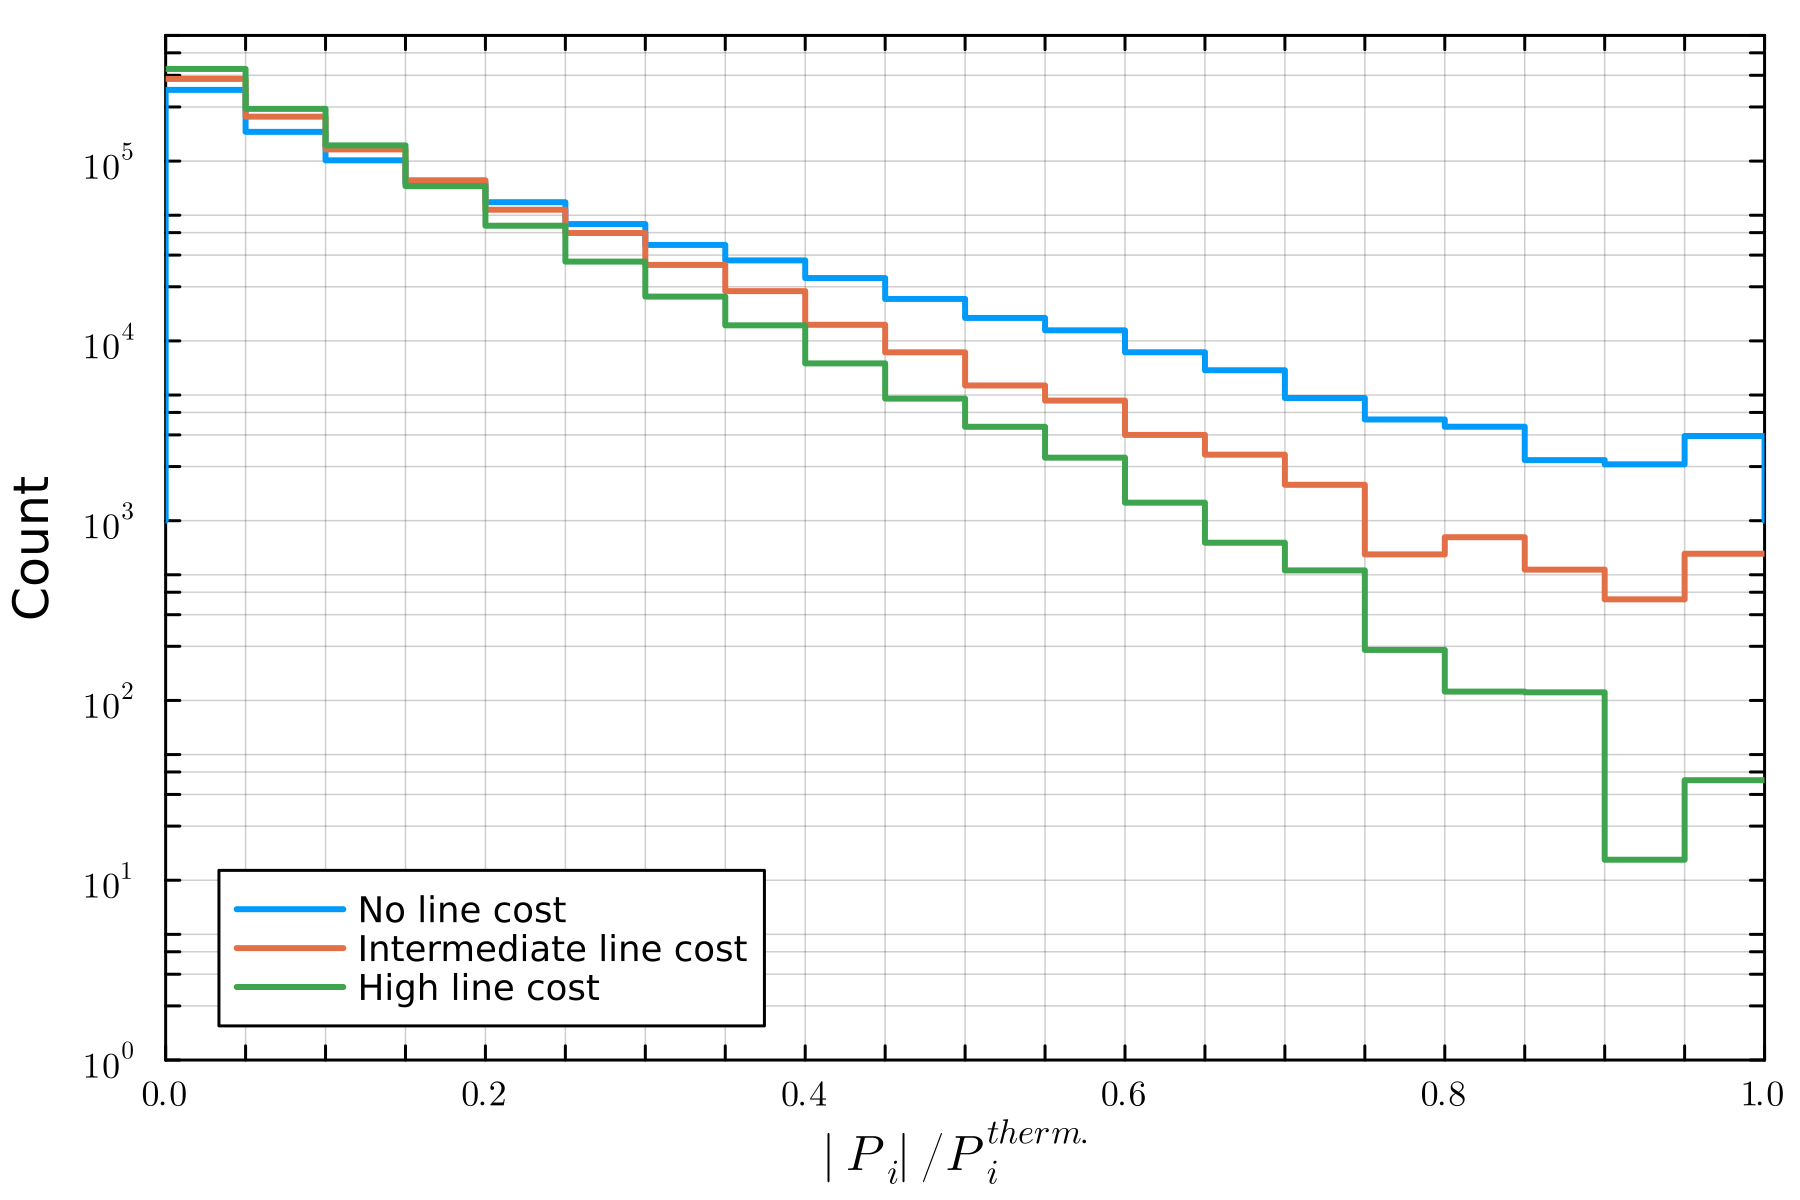

In [44]:
plot_histogram(line_rates_sample_0, "No line cost")
plot_histogram!(line_rates_sample_1000, "Intermediate line cost")
plot_histogram!(line_rates_sample_5000, "High line cost")

In [45]:
# savefig("figures/pantagruel_line_rate_distribution.png")

"/home/marc/repos/PowerData/doc/figures/pantagruel_line_rate_distribution.png"

Note that increasing the line cost further does not change the result significantly:

In [ ]:
line_rates_sample_10000 = compute_line_rates_sample(10000);

In [ ]:
line_rates_sample_20000 = compute_line_rates_sample(20000);

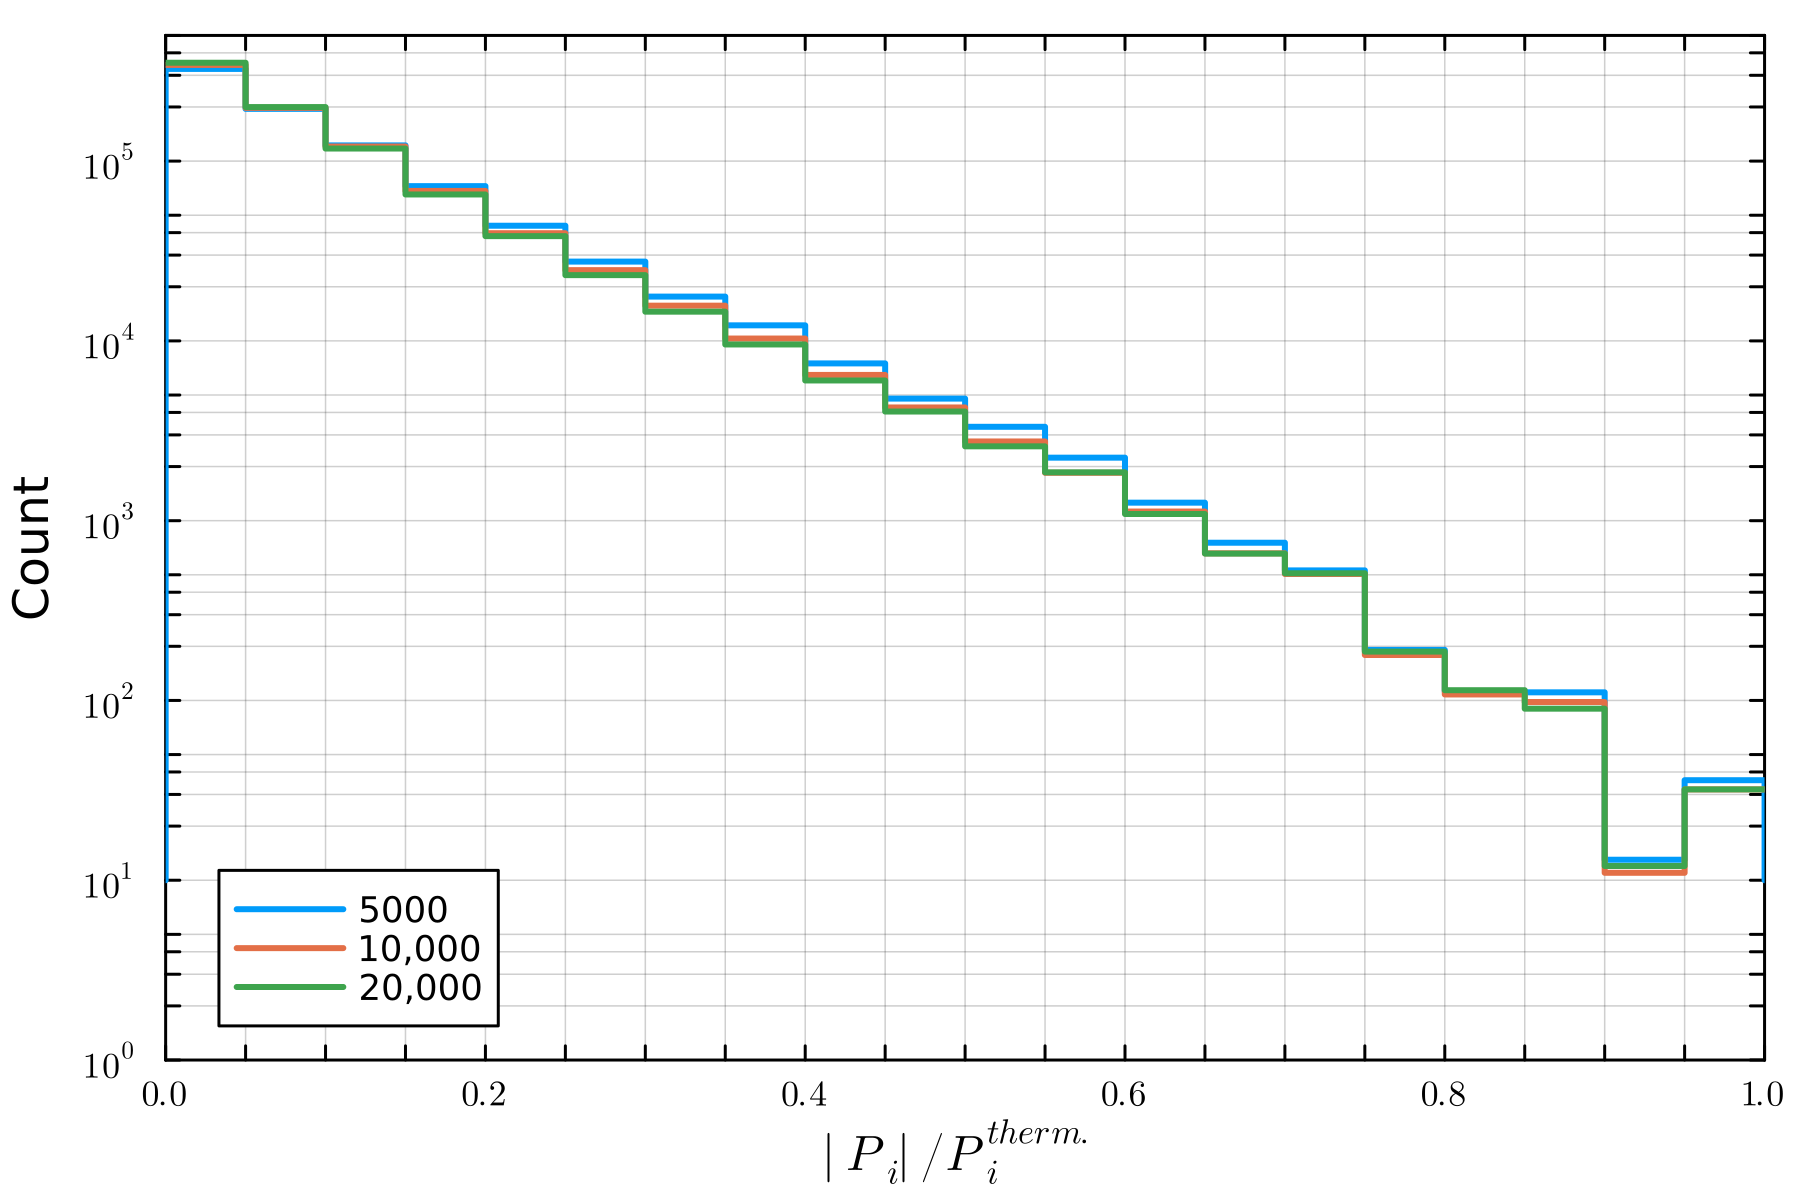

In [48]:
plot_histogram(line_rates_sample_5000, "5000")
plot_histogram!(line_rates_sample_10000, "10,000")
plot_histogram!(line_rates_sample_20000, "20,000")